# Web Scraping

Lots of great data is available online, but available through inconveniently formatted web pages. When this is the case, sometimes you can simply copy and paste the data into a .csv file and go on with your life. But if there are many records to parse and combine into a dataset, that might be impossible. Can we automate the collection of data from online sources?

This is called web scraping. Broadly speaking: Web scraping is legal, but what you plan to do with the results of your scraping might not be. In general, most sites do not want you to scrape them at this point, but there is not really a way to stop you if you are sufficiently motivated. Be careful to use server resources respectfully (not too many requests per unit time), think seriously about privacy concerns, and be careful who you share your work with and how it is used.

We'll be scraping data about used cars in Charlottesville from Craigslist, particularly this page: https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0

We'll use the `requests` package to get web pages off the Internet and into Python. Again, we'll use a header with a user-agent that masks our true identity so that we're not rejected by the server. This particular url points to the car listings for Craigslist in Charlottesville. To use requests, you pass a `url` for the page you want and a `header` that controls how you appear to the server to `requests.get`:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import requests # Page requests

header = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'} # How we wish to appear to CL
url = 'https://charlottesville.craigslist.org/search/cta?purveyor=owner#search=1~gallery~0~0' # The page we want to scrape
raw = requests.get(url,headers=header) # Get page

Now that we have that particular page available locally, we want to **parse** it and get results from it. To do that, we can use a package called `beautifulSoup` or `bs4`.

What does `beautifulSoup` do for us? Let's go to the web page of interest. You probably see something like this:

![Listings](./src/craigslist.png "Craigslist")

But if you "view page source" -- which is CTRL+U -- in Chrome, you see what the computer sees:

![Listings](./src/craigslist_source.png "Craigslist")

Since your web browser needs lots of instructions about how to render the text, pictures, and other content on your web page, there are a lot of clues about where the data live and how to extricate them from a page. These clues are called **tags**. If you wander the source for the search page on cars, you see a particular `class = "cl-static-search-result"` term appear attached to each listing:

![Listings](./src/listing.png "Craigslist")

This structure can be exploited to search the page for information. This kind of detective work -- looking at the page source, finding the interesting tags, and then searching the page with `beautifulSoup` -- is the basic job of web scraping.

What I do is look at the rendered page, find the text I want and copy it, then search for that text in the HTML code that the computer sees. When I find the text I want, I look for the tag nearby. Here, it's `cl-static-search-result`: That's what I'll want beautifulSoup to search for.

The following code chunk takes the raw content from `requests` and turns it into a beautifulSoup object, which can search the page and return results for us:

In [2]:
from bs4 import BeautifulSoup as soup # HTML parser
bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

Why is the argument `class_` and not just `class`? The word `class` is a reserved keyword for Python, and cannot be used by anyone else, similar to `True` and `False`. But since we want the `class = "cl-static-search-result"` terms, we need to use the `class_` argument to the `.find_all` method.

The `.find_all` function dredges the entire page and finds all the instances of `class = "cl-static-search-result"`, resulting in a list of entries. We can then parse the entries.

Parsing the entries can be a challenge! We have to go back to what a listing looks like, and look at the tags within the listing. They're typically `div` tags with a `class` like price or location. You then have to experiment a bit with `.find` and the HTML to make sure you're getting the information you want. For each listing, the `.find` method to search within the listing record for specific information, but it's typically still wrapped in the tag. To get the real information we want, we can then use `.get_text()`. I end up using a code chunk to experiment and play with a record to make sure I'm getting as close to what I want as possible.

In the code below, two more things happen. You don't need to do them in your work, but they're helpful to know about.

First, I would like to get the brand of the car from the post title, if possible. To do this, I split the title into words using `title.split()`, and then I use a list comprehension to look over every word in the title and check whether it appears in the `brands` list.

Second, I would like to get the year the car was built, if possible, so I can determine the vehicle's age. To do this, I use a thing called **regular expressions** that provides a language for expressing patterns. Do I remember how to do this off the top of my head? No, I read a few pages in a book and looked on StackOverflow for answers. Roughly, in order to express the idea "any year starting with 20xx," you can write `20[0-9][0-9]`, and for "any year starting with 19xx," you can write `19[0-9][0-9]`. The `[0-9]`'s act as wildcards for any digit. This allows me to use the `re` package to find any instances of year-like numbers in the title text, using `re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )`.

This is all nested in a for-loop over the listings, and the data is appended to a list.

In [3]:
import re # Regular expressions

brands = ['honda', 'dodge','toyota','ford','tesla','gmc','jeep','bmw','mitsubishi','mazda',
          'volvo','audi','volkswagen','chevy','chevrolet','acura','kia','subaru','lexus',
          'cadillac','buick','porsche','infiniti']

data = [] # We'll save our listings in this object
for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()
    price = listings[k].find('div',class_='price').get_text()
    link = listings[k].find(href=True)['href']
    # Get brand from the title string:
    words = title.split()
    hits = [word for word in words if word in brands] # Find brands in the title
    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]
    # Get years from title string:
    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title ) # Find year references
    if regex_search is None: # If no hits, record year as missing value
        year = np.nan
    else: # If hits, record year as first match
        year = regex_search.group(0)
    #
    data.append({'title':title,'price':price,'year':year,'link':link,'brand':brand})


With the data scraped from Craigslist, we can put it in a dataframe and wrangle it. Of course, price and year come in as text, not numbers, and need to be typecast/coerced:

In [4]:
## Wrangle the data
df = pd.DataFrame.from_dict(data)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025-df['year']
print(df.shape)
df.to_csv('./src/craigslist_cville_cars.csv') # Save data in case of a disaster
df.head()

(51, 6)


OSError: Cannot save file into a non-existent directory: 'src'

With the data in and wrangled, we can now do some analysis:

count       51.000000
mean      8457.823529
std      11335.936688
min       1000.000000
25%       2500.000000
50%       5000.000000
75%       8700.000000
max      69500.000000
Name: price, dtype: float64


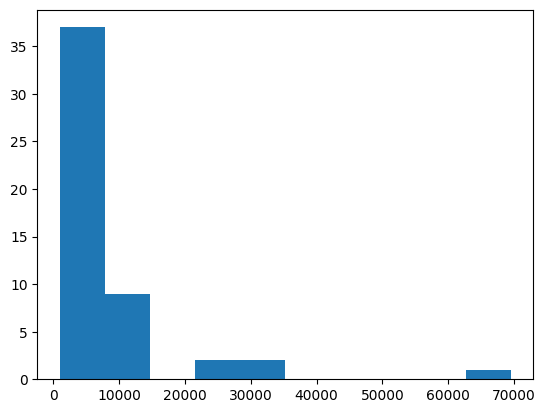

count    43.000000
mean     18.581395
std      13.636842
min       0.000000
25%      12.000000
50%      15.000000
75%      19.500000
max      75.000000
Name: age, dtype: float64


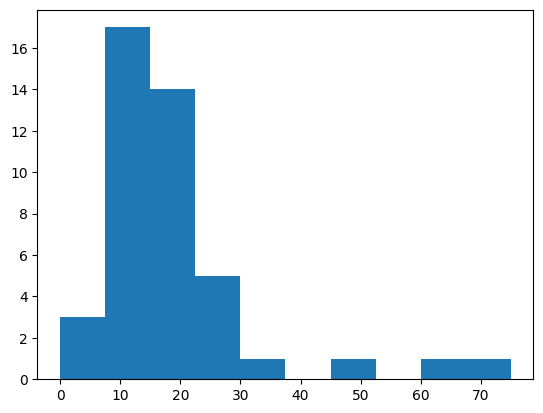

In [5]:
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()
print(df['age'].describe())
df['age'].hist(grid=False)
plt.show()

In [6]:
# Price by brand:
df.loc[:,['price','brand']].groupby('brand').describe()

price                                                          \
           count          mean           std      min       25%      50%   
brand                                                                      
bmw          2.0   7500.000000   9192.388155   1000.0   4250.00   7500.0   
dodge        1.0   4000.000000           NaN   4000.0   4000.00   4000.0   
ford        10.0  13085.000000  20333.880457   1500.0   3700.00   5650.0   
gmc          1.0  26700.000000           NaN  26700.0  26700.00  26700.0   
honda        7.0   4742.857143   2614.610961   1200.0   3150.00   4300.0   
jeep         1.0   8500.000000           NaN   8500.0   8500.00   8500.0   
kia          1.0   1500.000000           NaN   1500.0   1500.00   1500.0   
lexus        1.0   2500.000000           NaN   2500.0   2500.00   2500.0   
mazda        2.0  15870.000000  19968.695501   1750.0   8810.00  15870.0   
missing     16.0   8115.562500   8764.053955   1000.0   2450.00   5850.0   
toyota       6.0   4820.833333   2241.005169   2000.0   3118.75   4987.5   
volkswagen   1.0   2600.000000           NaN   2600.0   2600.00   2600.0   
volvo        2.0   7992.500000   5243.196782   4285.0   6138.75   7992.5   

                               
                 75%      max  
brand                          
bmw         10750.00  14000.0  
dodge        4000.00   4000.0  
ford        12737.50  69500.0  
gmc         26700.00  26700.0  
honda        6250.00   8900.0  
jeep         8500.00   8500.0  
kia          1500.00   1500.0  
lexus        2500.00   2500.0  
mazda       22930.00  29990.0  
missing      8049.25  32000.0  
toyota       6462.50   7500.0  
volkswagen   2600.00   2600.0  
volvo        9846.25  11700.0

In [7]:
# Age by brand:
df.loc[:,['age','brand']].groupby('brand').describe()

age                                                      
           count       mean        std   min    25%   50%    75%   max
brand                                                                 
bmw          2.0  19.500000  10.606602  12.0  15.75  19.5  23.25  27.0
dodge        0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
ford        10.0  19.200000  20.263816   6.0   9.75  13.0  15.50  75.0
gmc          0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
honda        6.0  14.833333   3.970726  10.0  12.25  14.0  18.00  20.0
jeep         0.0        NaN        NaN   NaN    NaN   NaN    NaN   NaN
kia          1.0  14.000000        NaN  14.0  14.00  14.0  14.00  14.0
lexus        1.0  24.000000        NaN  24.0  24.00  24.0  24.00  24.0
mazda        2.0   6.500000   9.192388   0.0   3.25   6.5   9.75  13.0
missing     13.0  23.000000  15.869257   4.0  14.00  18.0  24.00  62.0
toyota       5.0  16.000000   3.162278  11.0  15.00  17.0  18.00  19.0
volkswagen   1.0  19.000000        NaN  19.0  19.00  19.0  19.00  19.0
volvo        2.0  15.000000   5.656854  11.0  13.00  15.0  17.00  19.0

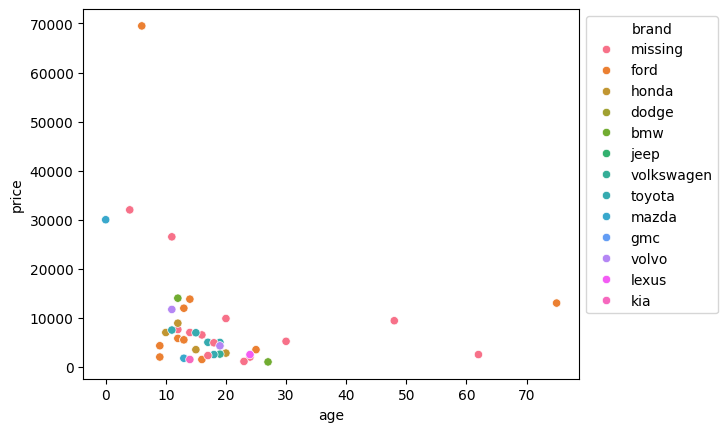

In [8]:
ax = sns.scatterplot(data=df, x='age', y='price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


           log_price   log_age
log_price   0.904928 -0.187464
log_age    -0.187464  0.286672
           log_price   log_age
log_price   1.000000 -0.388767
log_age    -0.388767  1.000000


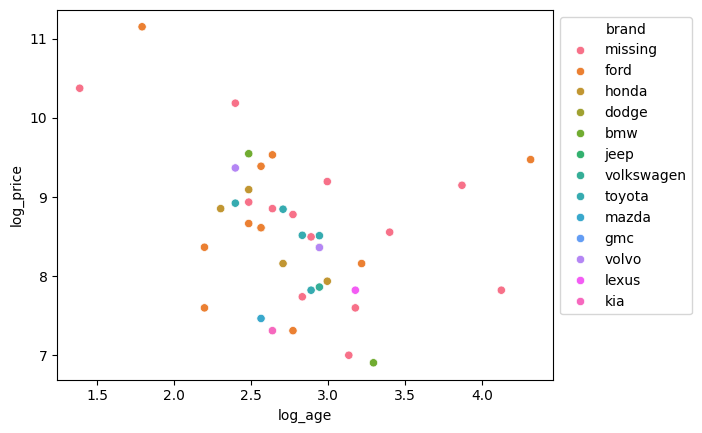

In [9]:
df['log_price'] = np.log(df['price'])
df['log_age'] = np.log(df['age'])

ax = sns.scatterplot(data=df, x='log_age', y='log_price',hue='brand')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

print(df.loc[:,['log_price','log_age']].cov())
print(df.loc[:,['log_price','log_age']].corr())

## The Lab:


1. Pick something else on Craigslist besides used cars: Musical instruments, roommates, antiques, etc. Look at the search page and its source code. Record which fields/data you would like to gather, and what kinds of basic EDA you'd do with it.
2. Get your search results of interest using `requests` and extract data from them using `beautifulSoup`, using code similar to what's above.
3. Wrangle your data into a dataframe and do some basic descriptions and plots. Try to find some interesting relationships or stories to tell about your data.

In [28]:
# 1

# I am choosing to look at pianos on Craigslist.

url = 'https://charlottesville.craigslist.org/search/sss?query=piano#search=2~gallery~0'

# I will be attempting to look at title, brand, type, and price.

# Some basic EDA I would like to do includes examining the range of prices and comparing prices by piano type. Additionally, I want to examine which
# types of pianos appear the most on Craigslist.

# 2

header = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:124.0) Gecko/20100101 Firefox/124.0'
}

raw = requests.get(url, headers = header)

bsObj = soup(raw.content,'html.parser') # Parse the html
listings = bsObj.find_all(class_="cl-static-search-result") # Find all listings of the kind we want

brands = ["yamaha", "casio", "baldwin", "steinway", "korg", "samick", "petrof", "bösendorfer", "schimmel", "fazioli", "bluthner", "sauter", "grotrian"]

data = []

for k in range( len(listings) ):
    title = listings[k].find('div',class_='title').get_text().lower()

    price_tag = listings[k].find('div', class_='price')
    if price_tag is None:
      price = np.nan
    else:
      price = price_tag.get_text()

    loc_tag = listings[k].find('div', class_='location')
    if loc_tag is None:
      location = "missing"
    else:
      location = loc_tag.get_text()

    link = listings[k].find(href=True)['href']

    words = title.split()
    hits = [word for word in words if word in brands]

    if len(hits) == 0:
        brand = 'missing'
    else:
        brand = hits[0]

    if 'grand' in title:
        ptype = 'grand'
    elif 'upright' in title:
        ptype = 'upright'
    elif 'digital' in title or 'keyboard' in title:
        ptype = 'digital'
    else:
        ptype = 'other'

    regex_search = re.search(r'20[0-9][0-9]|19[0-9][0-9]', title )
    if regex_search is None:
        year = np.nan
    else:
        year = regex_search.group(0)


    data.append({'title':title,'price':price, 'brand': brand, 'location': loc_tag, 'type': ptype, 'year':year,'link':link})








In [30]:
# 3

# Create dataframe
df = pd.DataFrame.from_dict(data)


#Clean
df['price'] = df['price'].astype(str)
df['price'] = df['price'].str.replace('$','')
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'],errors='coerce')
df['year'] = pd.to_numeric(df['year'],errors='coerce')
df['age'] = 2025 - df['year']
df.to_csv("craigslist_charlottsville_pianos.csv") # Saving it just in case

df['price'].isna().mean()
df.head(10)


# Due to missing information on craiglist postings, a lot of the year data is missing. This also means that "age" can not be calculated for a lot of the pianos.







,title,price,brand,location,type,year,link,age
0,steinway model l grand piano for sale: asking,8950.0,steinway,None,grand,NaN,https://charlottesville.craigslist.org/msg/d/a...,NaN
1,steinway model m grand piano for sale. asking,5950.0,steinway,None,grand,NaN,https://charlottesville.craigslist.org/msg/d/a...,NaN
2,betsy lynn piano model 1911,1.0,missing,[\n North Garden\n ...,other,1911.0,https://charlottesville.craigslist.org/msg/d/n...,114.0
3,roland fp-30x digital piano black with keyboar...,625.0,missing,[\n Crozet\n ...,digital,NaN,https://charlottesville.craigslist.org/msg/d/w...,NaN
4,daewoo/ gulbransen baby grand digital piano ke...,200.0,missing,[\n Charlottesville\n ...,grand,NaN,https://charlottesville.craigslist.org/msg/d/c...,NaN
5,grand piano co. upright piano,150.0,missing,[\n Elkton Va\n ...,grand,NaN,https://charlottesville.craigslist.org/for/d/e...,NaN
6,knabe baby grand piano,1200.0,missing,None,grand,NaN,https://charlottesville.craigslist.org/msg/d/e...,NaN
7,imperial upright piano,280.0,missing,[\n Esmont\n ...,upright,NaN,https://charlottesville.craigslist.org/msg/d/e...,NaN
8,free piano,0.0,missing,[\n Palmyra\n ...,other,NaN,https://charlottesville.craigslist.org/msg/d/t...,NaN
9,free cabine howard grand piano,0.0,missing,[\n Stanardsville\n ...,grand,NaN,https://charlottesville.craigslist.org/fuo/d/s...,NaN


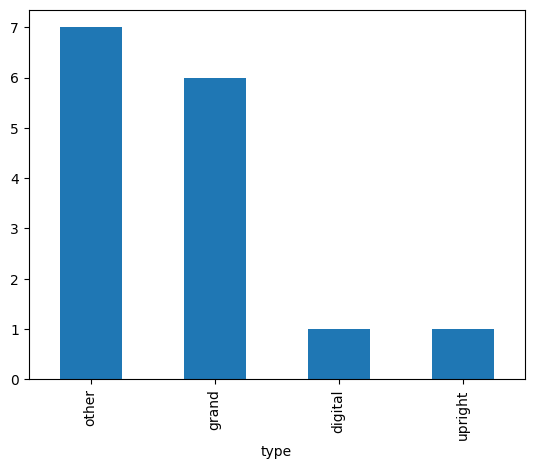

count      14.000000
mean     1372.928571
std      2667.732989
min         0.000000
25%        52.500000
50%       240.000000
75%       887.500000
max      8950.000000
Name: price, dtype: float64


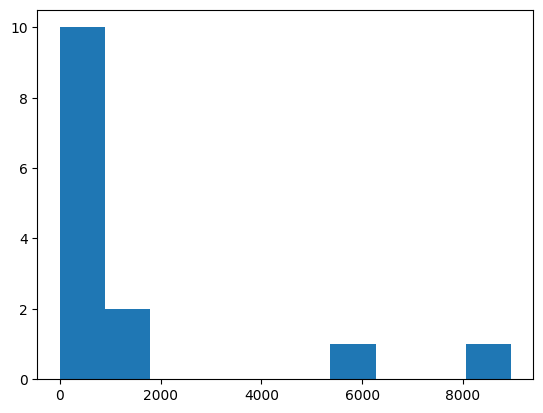

In [32]:
df['type'].value_counts().plot(kind='bar')
plt.show()
print(df['price'].describe())
df['price'].hist(grid=False)
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128222 (\N{TELEPHONE RECEIVER}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127949 (\N{RACING MOTORCYCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


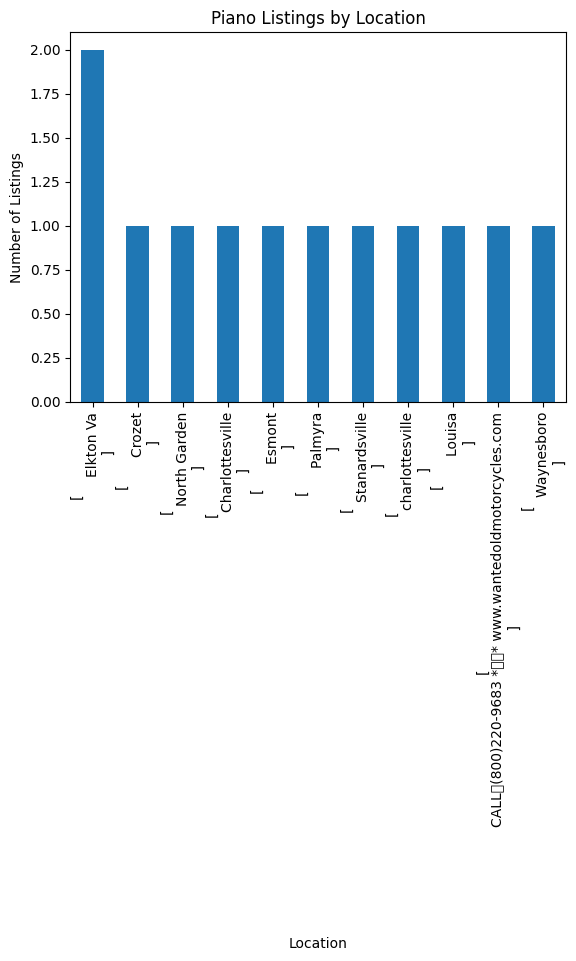

In [33]:
df['location'].value_counts().plot(kind='bar')
plt.title("Piano Listings by Location")
plt.xlabel("Location")
plt.ylabel("Number of Listings")
plt.show()

In [34]:
# Examining price by piano brand
df.loc[:,['price','type']].groupby('type').describe()

# Examining price by piano type
df.loc[:,['price','brand']].groupby('brand').describe()





price                                                            \
         count         mean          std     min     25%     50%     75%   
brand                                                                      
missing   11.0   329.181818   414.787131     0.0    10.5   195.0   452.5   
steinway   2.0  7450.000000  2121.320344  5950.0  6700.0  7450.0  8200.0   
yamaha     1.0   700.000000          NaN   700.0   700.0   700.0   700.0   

                  
             max  
brand             
missing   1200.0  
steinway  8950.0  
yamaha     700.0

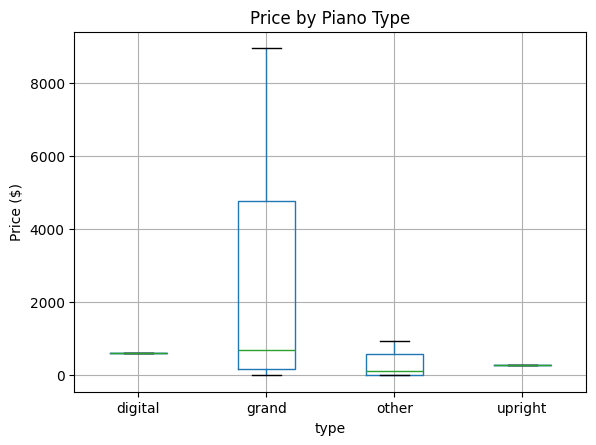

In [35]:
df.boxplot(column='price', by='type')
plt.suptitle('')
plt.title('Price by Piano Type')
plt.ylabel('Price ($)')
plt.show()

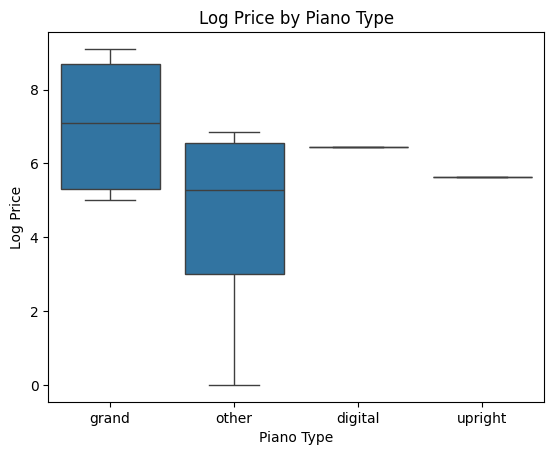

In [36]:
df_price = df[(df['price'] > 0)].copy()

df_price['log_price'] = np.log(df_price['price'])

sns.boxplot(data=df_price, x='type', y='log_price')
plt.title("Log Price by Piano Type")
plt.ylabel("Log Price")
plt.xlabel("Piano Type")
plt.show()

In [37]:
# Summary of findings

# The prices of a piano is dependent on what type it is, with grand pianos generally being the most expensive.

# Some of the prices are listed as 0. This makes sense, however, as many people on Craigslist are simply trying to get rid of things in their house.
